In [2]:
library(plyr)
library(dplyr)
library(poLCA)
library(ggplot2)
#library(ggparallel)
#library(igraph)
library(tidyr)
#library(knitr)
library(bigrquery)
library(stringr)
#library(data.table)
library(sjmisc);

In [16]:
bq_auth(use_oob = TRUE)

In [17]:
PROJECT_ID <- "dcw-data-platform-analysis"

In [4]:
sql_query1 <- "
    SELECT *, DATE_DIFF(DELIVERY_DATE, ORDER_DATE, DAY) AS DATE_DIFF,
    EXTRACT(DAYOFWEEK FROM DELIVERY_DATE) AS WEEK_DAY,
    EXTRACT(MONTH FROM DELIVERY_DATE) AS MONTH
    FROM `dcw-data-platform-analysis.Bui.CPCW_DELIVERY`
    WHERE ORDER_DATE >= '2019-01-01' AND ORDER_DATE <= '2019-05-01'
    AND DELIVERY_CHARGE IS NOT NULL
    AND CSC IS NOT NULL
"

sql_query2 <- "
    SELECT *, DATE_DIFF(DELIVERY_DATE, ORDER_DATE, DAY) AS DATE_DIFF,
    EXTRACT(DAYOFWEEK FROM DELIVERY_DATE) AS WEEK_DAY,
    EXTRACT(MONTH FROM DELIVERY_DATE) AS MONTH
    FROM `dcw-data-platform-analysis.Bui.CPCW_DELIVERY`
    WHERE ORDER_DATE >= '2020-01-01'
    AND DELIVERY_CHARGE IS NOT NULL
    AND CSC IS NOT NULL
"
# Sunday is equal to 1, the first day of the week
# Exclude NULL (NA) observations

In [5]:
# Collect specified datasets

data_prior <- bq_table_download(
    bq_project_query(
        PROJECT_ID,
        query = sql_query1
    )
)

data_post <- bq_table_download(
    bq_project_query(
        PROJECT_ID,
        query = sql_query2
    )
)

In [6]:
# Basic inspection
summary(data_prior)
summary(data_post)

    MA_CODE            MA               PROD_CD       PRODUCT_DESC      
 Min.   :   3.0   Length:916953      Min.   :   598   Length:916953     
 1st Qu.: 100.0   Class :character   1st Qu.:171947   Class :character  
 Median : 102.0   Mode  :character   Median :214643   Mode  :character  
 Mean   : 407.5                      Mean   :210254                     
 3rd Qu.: 123.0                      3rd Qu.:236114                     
 Max.   :2048.0                      Max.   :999279                     
                                                                        
    BRAND           PLU_RETAIL_PRICE     BAND_FIFTY        CREDIT_BAND    
 Length:916953      Min.   :    9.97   Min.   :    50.0   Min.   :   100  
 Class :character   1st Qu.:  219.00   1st Qu.:   250.0   1st Qu.:   250  
 Mode  :character   Median :  299.00   Median :   300.0   Median :   500  
                    Mean   :  380.88   Mean   :   906.1   Mean   :  1003  
                    3rd Qu.:  420.00   3r

    MA_CODE            MA               PROD_CD       PRODUCT_DESC      
 Min.   :   3.0   Length:1002078     Min.   :    92   Length:1002078    
 1st Qu.: 100.0   Class :character   1st Qu.:195220   Class :character  
 Median : 102.0   Mode  :character   Median :233481   Mode  :character  
 Mean   : 391.5                      Mean   :291724                     
 3rd Qu.: 123.0                      3rd Qu.:265259                     
 Max.   :2048.0                      Max.   :999279                     
                                                                        
    BRAND           PLU_RETAIL_PRICE    BAND_FIFTY        CREDIT_BAND      
 Length:1002078     Min.   :  12.97   Min.   :    50.0   Min.   :   100.0  
 Class :character   1st Qu.: 229.00   1st Qu.:   250.0   1st Qu.:   250.0  
 Mode  :character   Median : 299.99   Median :   300.0   Median :   500.0  
                    Mean   : 382.26   Mean   :   788.7   Mean   :   888.6  
                    3rd Qu.: 429.00 

In [7]:
# Whether or not a time-slot was selected 
classifier_func_slot <- function(x) {
    sum(ifelse(str_contains(x, "Q"), 1, 0))
}

# Delivery when time slot is not involved
classifier_func_no_slot <- function(x) {
    sum(ifelse(str_contains(x, "D"), 1, 0))
}
# Whether or not installation was selected
classifier_func_insta <- function(x) {
    sum(ifelse(str_contains(x, c("G", "I", "J", "K", "L", "M", "N", "P", "R")), 1, 0))
}

# Whether or not disposal was selected
classifier_func_colle <- function(x) {
    sum(ifelse(str_contains(x, c("F", "K", "M", "N", "P", "S")), 1, 0))
}

In [8]:
# Manifest variables
data_prior$INSTALLATION <- sapply(data_prior$SRV_TYPS, FUN = classifier_func_insta)
data_prior$COLLECTION <- sapply(data_prior$SRV_TYPS, FUN = classifier_func_colle)
data_prior$TIME_SLOT <- sapply(data_prior$SRV_TYPS, FUN = classifier_func_slot)
data_prior$WEEKEND_DELV <- ifelse(data_prior$WEEK_DAY %in% c(1, 7), 1, 0)

#data_2020$DELV <- sapply(data_2020$SRV_TYPS, FUN = classifier_func_no_slot)
#data_2020$DELV_EXTRA <- sum(data_2020$INSTALLATION:data_2020$WEEKEND_DELV)

In [9]:
# Manifest variables
data_post$INSTALLATION <- sapply(data_post$SRV_TYPS, FUN = classifier_func_insta)
data_post$COLLECTION <- sapply(data_post$SRV_TYPS, FUN = classifier_func_colle)
data_post$TIME_SLOT <- sapply(data_post$SRV_TYPS, FUN = classifier_func_slot)
data_post$WEEKEND_DELV <- ifelse(data_post$WEEK_DAY %in% c(1, 7), 1, 0)


In [10]:
data_prior$DELIVERY_CHARGE <- abs(data_prior$DELIVERY_CHARGE)
data_post$DELIVERY_CHARGE <- abs(data_post$DELIVERY_CHARGE)

In [11]:
colnames(data_post)

[1] "MA_CODE"          "MA"               "PROD_CD"          "PRODUCT_DESC"    
 [5] "BRAND"            "PLU_RETAIL_PRICE" "BAND_FIFTY"       "CREDIT_BAND"     
 [9] "ORDER_STORE"      "ORDER_DATE"       "DELIVERY_DATE"    "OUTCODE"         
[13] "DLC"              "CSC"              "SRV_TYPS"         "VOLUME"          
[17] "DELIVERY_CHARGE"  "CUSTOMER_SEGMENT" "DATE_DIFF"        "WEEK_DAY"        
[21] "MONTH"            "INSTALLATION"     "COLLECTION"       "TIME_SLOT"       
[25] "WEEKEND_DELV"

In [71]:
prior.table <- data_prior %>% summarise(MA_number = length(unique(MA)),
                                        Min_charge = min(DELIVERY_CHARGE),
                                        Max_charge = max(DELIVERY_CHARGE),
                                        Min_time = min(DATE_DIFF),
                                        Max_time = max(DATE_DIFF),
                                        Time_slot_order = sum(TIME_SLOT),
                                        Installation_order = sum(INSTALLATION),
                                        Collection_order = sum(COLLECTION),
                                        Total_order = nrow(data_prior))

post.table <- data_post %>% summarise(MA_number = length(unique(MA)),
                                        Min_charge = min(DELIVERY_CHARGE),
                                        Max_charge = max(DELIVERY_CHARGE),
                                        Min_time = min(DATE_DIFF),
                                        Max_time = max(DATE_DIFF),
                                        Time_slot_order = sum(TIME_SLOT),
                                        Installation_order = sum(INSTALLATION),
                                        Collection_order = sum(COLLECTION),
                                        Total_order = nrow(data_post))

total.table <- rbind(prior.table, post.table)
total.table$Data_set <- c("2019 data", "2020 data")

total.table <- total.table %>% dplyr::select(Data_set, MA_number:Total_order)

In [17]:
max(data_prior$ORDER_DATE) - min(data_prior$ORDER_DATE)
max(data_post$ORDER_DATE) - min(data_post$ORDER_DATE)
max(data_post$ORDER_DATE)
nrow(data_prior) + nrow(data_post)

Time difference of 120 days

Time difference of 121 days

[1] "2020-05-01"

[1] 1919031

In [72]:
total.table

Data_set  MA_number Min_charge Max_charge Min_time Max_time Time_slot_order
1 2019 data 32        0          501.99     0        30       95674          
2 2020 data 32        0          375.00     0        30       90313          
  Installation_order Collection_order Total_order
1 234214             265063            916953    
2 185599             287949           1002078

# Delivery charge distribution

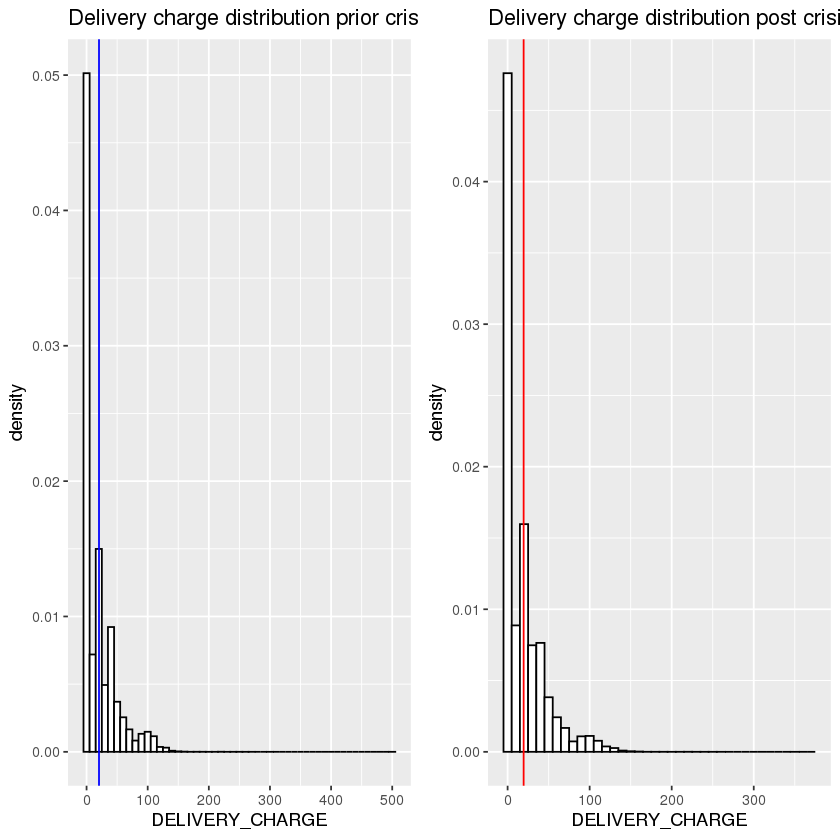

In [42]:
charge1 <- ggplot(data_prior, aes(x = DELIVERY_CHARGE)) + geom_histogram(aes(y = ..density..),colour = "black", fill = "white", binwidth = 10) +
#stat_function(fun=dgamma,args=fitdistr(data_prior$DELIVERY_CHARGE,"gamma")$estimate)+       
#xlim(0,250) +
geom_vline(xintercept = mean(data_prior$DELIVERY_CHARGE), color="blue")+
ggtitle("Delivery charge distribution prior crisis data")

charge2 <- ggplot(data_post, aes(x = DELIVERY_CHARGE)) + geom_histogram(aes(y = ..density..),colour = "black", fill = "white", binwidth = 10) +
           #xlim(0,250) +
geom_vline(xintercept = mean(data_post$DELIVERY_CHARGE), color="red")+
ggtitle("Delivery charge distribution post crisis data")

grid.arrange(charge1, charge2, nrow=1)

# Delivery lead time distribution

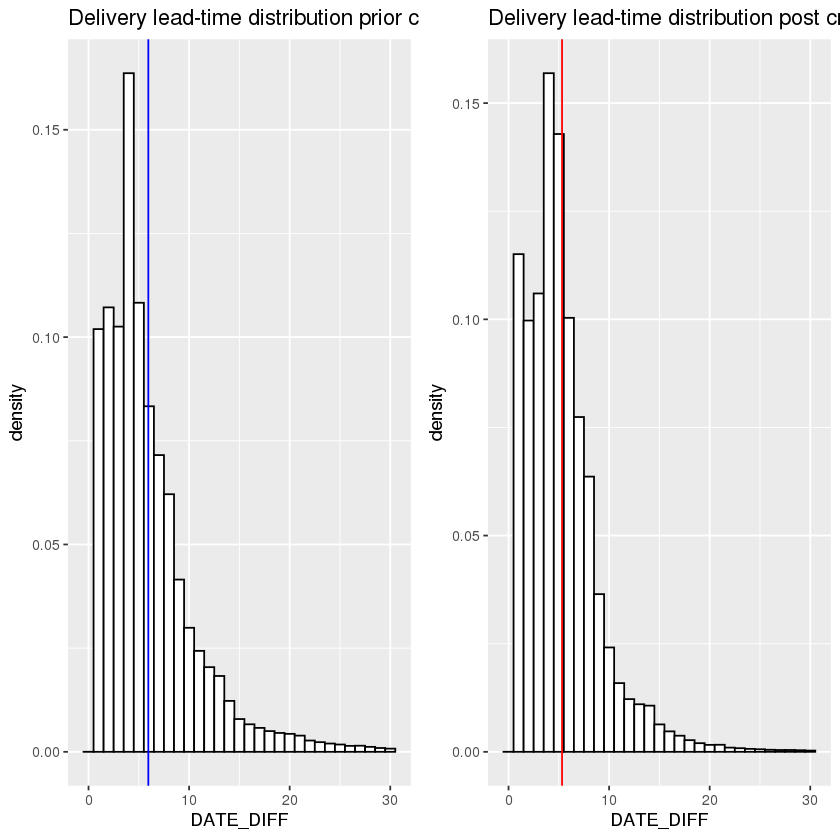

In [44]:
time1 <- ggplot(data_prior, aes(x = DATE_DIFF)) + geom_histogram(aes(y = ..density..),colour = "black", fill = "white", binwidth = 1) +
#stat_function(fun=dgamma,args=fitdistr(data_prior$DELIVERY_CHARGE,"gamma")$estimate)+       
#xlim(0,250) +
geom_vline(xintercept = mean(data_prior$DATE_DIFF), color="blue")+
ggtitle("Delivery lead-time distribution prior crisis data")

time2 <- ggplot(data_post, aes(x = DATE_DIFF)) + geom_histogram(aes(y = ..density..),colour = "black", fill = "white", binwidth = 1) +
           #xlim(0,250) +
geom_vline(xintercept = mean(data_post$DATE_DIFF), color="red")+
ggtitle("Delivery lead-time distribution post crisis data")

grid.arrange(time1, time2, nrow=1)

# Number of order by month

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



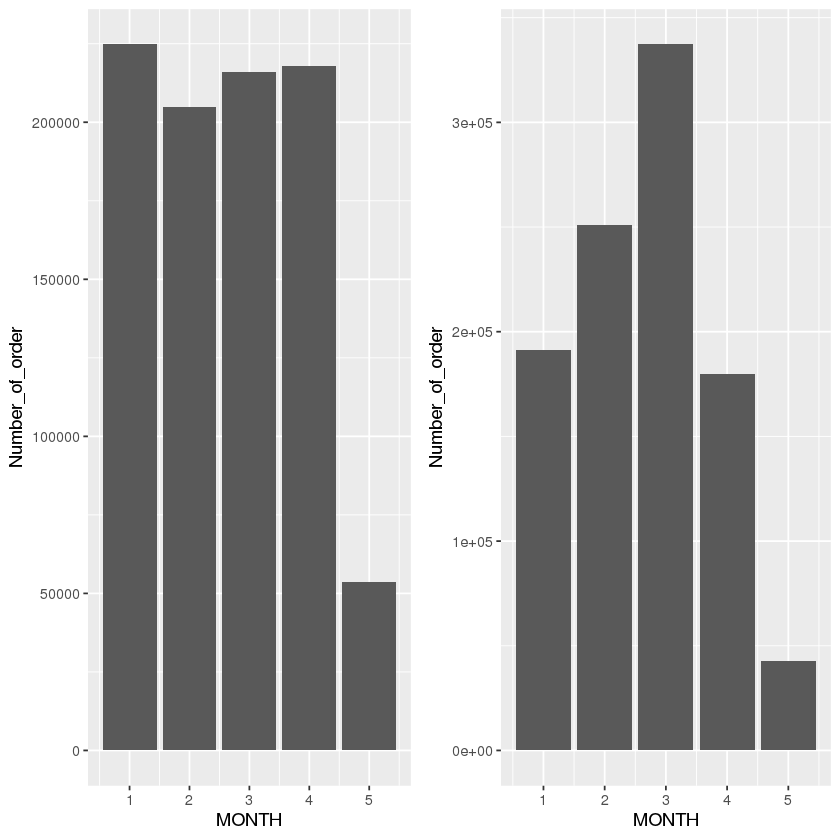

In [78]:
o1 <- data_prior %>% group_by(MONTH) %>%
    summarise(Number_of_order = n()) %>%
#arrange(desc(Number_of_order)) %>%
    ggplot(aes(x = MONTH, y = Number_of_order)) + geom_col() + labs("2019 data")

o2 <- data_post %>% group_by(MONTH) %>%
    summarise(Number_of_order = n()) %>%
    ggplot(aes(x = MONTH, y = Number_of_order)) + geom_col() + labs("2020 data")

grid.arrange(o1, o2, nrow = 1)

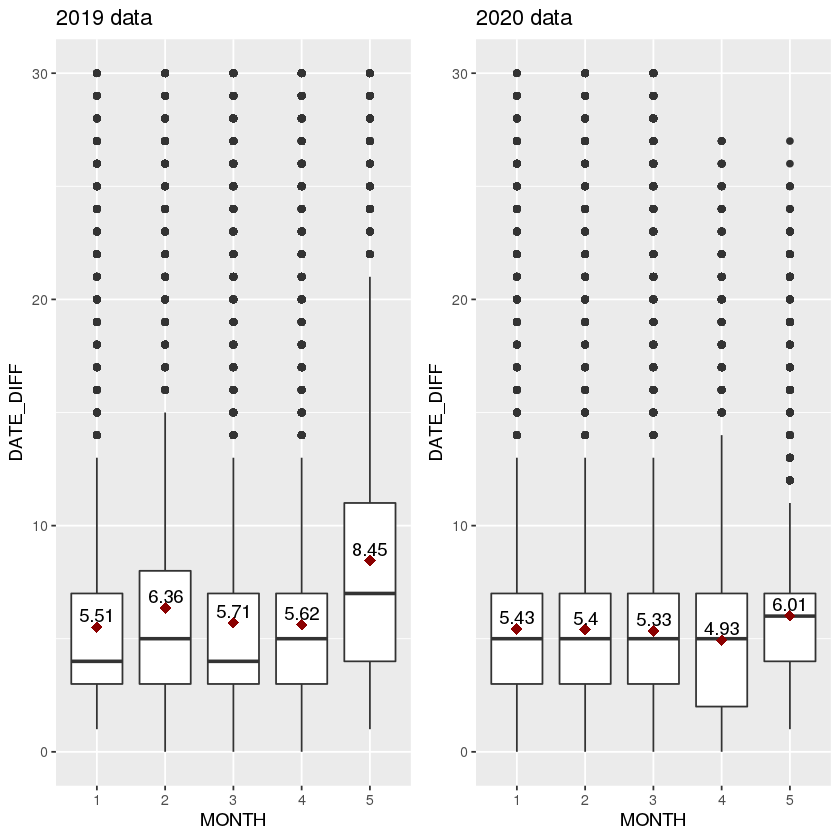

In [79]:
means1 <- aggregate(DATE_DIFF ~  MONTH, data_prior, mean) %>%
            mutate(DATE_ROU = round(DATE_DIFF,2))

p1 <- ggplot(data=data_prior, aes(x=as.factor(MONTH), y=DATE_DIFF)) + geom_boxplot(show.legend = FALSE) +
      stat_summary(fun=mean, colour="darkred", geom="point", 
               shape=18, size=3,show.legend = FALSE) + 
      geom_text(data = means1, aes(label = DATE_ROU, y = DATE_ROU + 0.5))+
      labs(x = "MONTH", title = "2019 data")

means2 <- aggregate(DATE_DIFF ~  MONTH, data_post, mean) %>%
            mutate(DATE_ROU = round(DATE_DIFF,2))

p2 <- ggplot(data=data_post, aes(x=as.factor(MONTH), y=DATE_DIFF)) + geom_boxplot(show.legend = FALSE) +
      stat_summary(fun=mean, colour="darkred", geom="point", 
               shape=18, size=3,show.legend = FALSE) + 
      geom_text(data = means2, aes(label = DATE_ROU, y = DATE_ROU + 0.5))+
      labs(x = "MONTH", title = "2020 data")
grid.arrange(p1, p2, nrow=1)

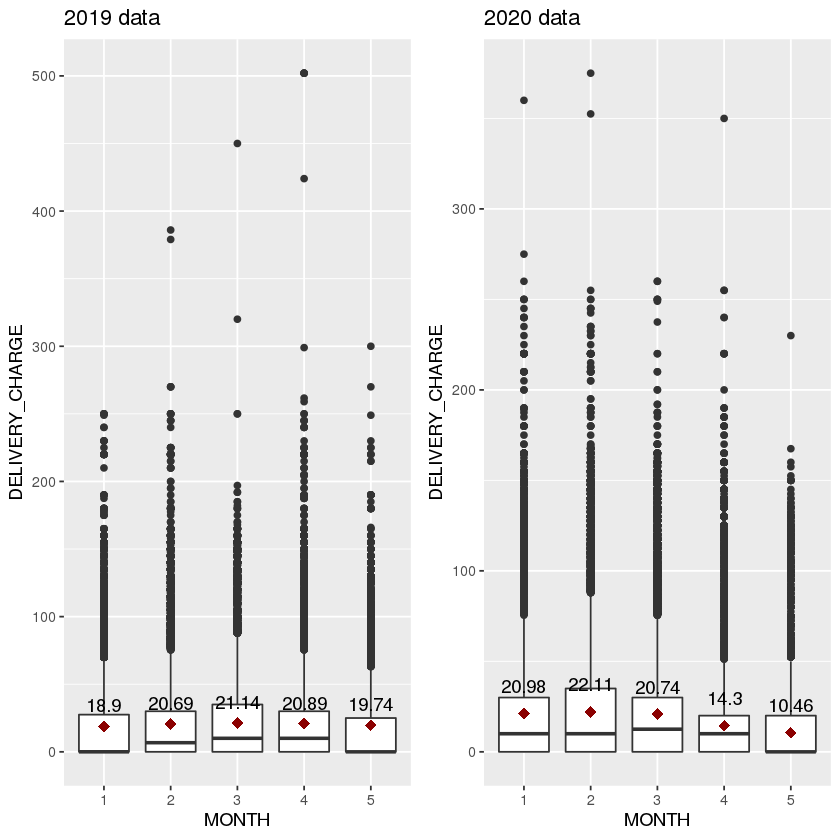

In [80]:
means3 <- aggregate(DELIVERY_CHARGE ~  MONTH, data_prior, mean) %>%
            mutate(DEL_ROU = round(DELIVERY_CHARGE,2))

p3 <- ggplot(data=data_prior, aes(x=as.factor(MONTH), y=DELIVERY_CHARGE)) + geom_boxplot(show.legend = FALSE) +
      stat_summary(fun=mean, colour="darkred", geom="point", 
               shape=18, size=3,show.legend = FALSE) + 
      geom_text(data = means3, aes(label = DEL_ROU, y = DEL_ROU + 15))+
      labs(x = "MONTH", title = "2019 data")

means4 <- aggregate(DELIVERY_CHARGE ~  MONTH, data_post, mean) %>%
            mutate(DEL_ROU = round(DELIVERY_CHARGE,2))

p4 <- ggplot(data=data_post, aes(x=as.factor(MONTH), y=DELIVERY_CHARGE)) + geom_boxplot(show.legend = FALSE) +
      stat_summary(fun=mean, colour="darkred", geom="point", 
               shape=18, size=3,show.legend = FALSE) + 
      geom_text(data = means4, aes(label = DEL_ROU, y = DEL_ROU + 15))+
      labs(x = "MONTH", title = "2020 data")
grid.arrange(p3, p4, nrow=1)

In [41]:
sum(1,2,34)
#data_2020 <- data_2020 %>% select(-DELV_EXTRA)
data_2020$DELV_EXTRA <- data_2020$INSTALLATION+data_2020$COLLECTION+data_2020$TIME_SLOT+data_2020$WEEKEND_DELV

[1] 37

In [65]:
means1

MONTH DATE_DIFF DATE_ROU
1 1     5.509245  5.51    
2 2     6.360383  6.36    
3 3     5.713537  5.71    
4 4     5.619818  5.62    
5 5     8.453158  8.45

In [42]:
# Check the data class and missing values
str(data_2020)
summary(data_2020)

tibble [1,070,881 × 28] (S3: tbl_df/tbl/data.frame)
 $ MA_CODE         : int [1:1070881] 87 87 87 87 87 87 2038 2038 2047 87 ...
 $ MA              : chr [1:1070881] "0087: TV STANDS AND BRACKETS" "0087: TV STANDS AND BRACKETS" "0087: TV STANDS AND BRACKETS" "0087: TV STANDS AND BRACKETS" ...
 $ PROD_CD         : num [1:1070881] 229208 93013 42660 42660 42660 ...
 $ PRODUCT_DESC    : chr [1:1070881] "229208    :  LOG L105MDF18" "093013    :  LOG S800BG11X" "042660    :  LOG S105BG13" "042660    :  LOG S105BG13" ...
 $ BRAND           : chr [1:1070881] "LOG: LOGIK" "LOG: LOGIK" "LOG: LOGIK" "LOG: LOGIK" ...
 $ PLU_RETAIL_PRICE: num [1:1070881] 40 50 50 50 50 ...
 $ BAND_FIFTY      : num [1:1070881] 50 50 50 50 50 50 2500 1750 950 50 ...
 $ CREDIT_BAND     : num [1:1070881] 100 100 100 100 100 100 2500 2500 1000 100 ...
 $ ORDER_STORE     : int [1:1070881] 4944 4944 2298 4944 2412 1807 4944 4943 4944 4944 ...
 $ ORDER_DATE      : Date[1:1070881], format: "2020-03-08" "2020-03-08" ...
 $ 

    MA_CODE            MA               PROD_CD       PRODUCT_DESC      
 Min.   :   3.0   Length:1070881     Min.   :    92   Length:1070881    
 1st Qu.: 100.0   Class :character   1st Qu.:195206   Class :character  
 Median : 102.0   Mode  :character   Median :233481   Mode  :character  
 Mean   : 387.8                      Mean   :290824                     
 3rd Qu.: 123.0                      3rd Qu.:265256                     
 Max.   :2048.0                      Max.   :999279                     
                                                                        
    BRAND           PLU_RETAIL_PRICE    BAND_FIFTY        CREDIT_BAND      
 Length:1070881     Min.   :  12.97   Min.   :    50.0   Min.   :   100.0  
 Class :character   1st Qu.: 229.00   1st Qu.:   250.0   1st Qu.:   250.0  
 Mode  :character   Median : 299.99   Median :   300.0   Median :   500.0  
                    Mean   : 383.17   Mean   :   799.1   Mean   :   899.2  
                    3rd Qu.: 429.00 

In [43]:
# Create a data copy
data_2020$ID <- seq.int(nrow(data_2020))
data_2020_latent <- data_2020 %>% dplyr::select(ID, MA:DELV_EXTRA, -c(PROD_CD, PRODUCT_DESC, SRV_TYPS))

# Change to categorical variables
data_2020_latent$TIME_SLOT <- as.factor(data_2020_latent$TIME_SLOT + 1)
data_2020_latent$WEEKEND_DELI <- as.factor(data_2020_latent$WEEKEND_DELV + 1)
data_2020_latent$INSTALLATION <- as.factor(data_2020_latent$INSTALLATION + 1)
data_2020_latent$COLLECTION <- as.factor(data_2020_latent$COLLECTION + 1)
data_2020_latent$MA <- as.factor(data_2020_latent$MA)
data_2020_latent$CSC <- as.factor(data_2020_latent$CSC)

In [10]:
# Prep latent class inputs
# Non-covariate
f <- cbind(TIME_SLOT,WEEKEND_DELI,INSTALLATION,COLLECTION) ~ 1

# MA covariate
f.ma <- cbind(TIME_SLOT,WEEKEND_DELI,INSTALLATION,COLLECTION) ~ MA

# CSC covariate
f.csc <- cbind(TIME_SLOT,WEEKEND_DELI,INSTALLATION,COLLECTION) ~ CSC

# Both covariates
f.ma.csc <- cbind(TIME_SLOT,WEEKEND_DELI,INSTALLATION,COLLECTION) ~ MA + CSC

# 13/08: CSC and postal code relations

In [3]:
load("data_2020_processed.rda")

In [4]:
colnames(data_2020)

[1] "MA_CODE"          "MA"               "PROD_CD"          "PRODUCT_DESC"    
 [5] "BRAND"            "PLU_RETAIL_PRICE" "BAND_FIFTY"       "CREDIT_BAND"     
 [9] "ORDER_STORE"      "ORDER_DATE"       "DELIVERY_DATE"    "OUTCODE"         
[13] "DLC"              "CSC"              "SRV_TYPS"         "VOLUME"          
[17] "DELIVERY_CHARGE"  "CUSTOMER_SEGMENT" "DATE_DIFF"        "WEEK_DAY"        
[21] "MONTH"            "INSTALLATION"     "COLLECTION"       "TIME_SLOT"       
[25] "WEEKEND_DELV"     "NEXT_DAY"         "DELV_EXTRA"       "ID"

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by total



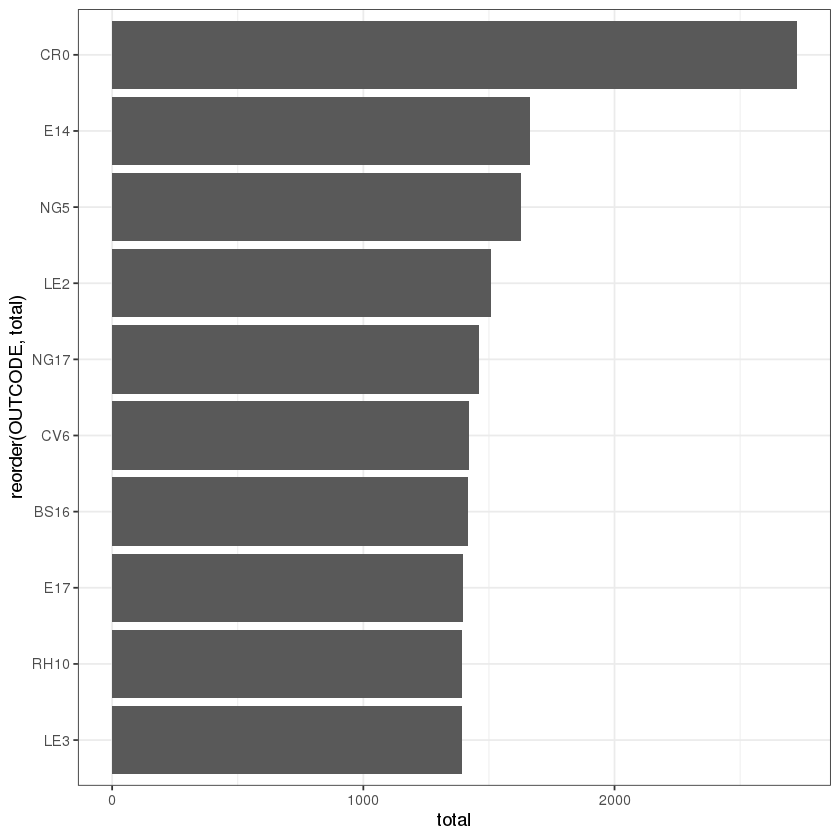

In [11]:
#table(data_2020$OUTCODE)
data_2020 %>% group_by(OUTCODE) %>% summarise(total = n()) %>%
                                arrange(desc(total)) %>% top_n(10) %>%
                                ggplot(aes(x = reorder(OUTCODE, total), y = total)) +
                                geom_col() +
                                coord_flip() +
                                theme_bw()


In [14]:
top_10_list <- data_2020 %>% filter(OUTCODE %in% c("CR0","E14","NG5","LE2","NG17",
                                                   "CV6","BS16","E17","RH10","LE3"))
table(top_10_list$OUTCODE)


BS16  CR0  CV6  E14  E17  LE2  LE3 NG17  NG5 RH10 
1417 2725 1421 1664 1395 1507 1393 1460 1626 1394 

In [15]:
2725/nrow(data_2020)

[1] 0.002719349

In [18]:
csc.query <- "
              SELECT * FROM `dcw-data-platform-analysis.Bui.CPCW_delivery_frequency`
              WHERE OUTCODE IN ('CR0','E14','LE2','BS16','NG5','NG17','BT36')
"


In [19]:
data_csc <- bq_table_download(
    bq_project_query(
        PROJECT_ID,
        query = csc.query
    )
)

In [21]:
data_csc %>% distinct()

CSC                DLC   OUTCODE
1  Newark             74309 LE2    
2  Newark             74309 NG5    
3  Newark             74309 NG17   
4  Newark             74309 NG17   
5  Newark             74309 LE2    
6  Newark             74309 NG5    
7  Belfast            74440 BT36   
8  Belfast            74440 BT36   
9  Bristol            74250 BS16   
10 Bristol            74250 BS16   
11 Tilbury            74110 E14    
12 Tilbury            74110 E14    
13 Snodland           74260 CR0    
14 Snodland           74260 CR0    
15 Birmingham         74290 LE2    
16 Birmingham         74290 LE2    
17 Gillingham         74266 CR0    
18 Gillingham         74266 CR0    
19 Tilbury Gillingham 74111 E14    
20 Tilbury Gillingham 74111 E14    
   Type                                           
1  Technical Install (Gas, Electric, Built in etc)
2  Technical Install (Gas, Electric, Built in etc)
3  Technical Install (Gas, Electric, Built in etc)
4  General                                        
5  General                                        
6  General                                        
7  General                                        
8  Technical Install (Gas, Electric, Built in etc)
9  General                                        
10 Technical Install (Gas, Electric, Built in etc)
11 Technical Install (Gas, Electric, Built in etc)
12 General                                        
13 Technical Install (Gas, Electric, Built in etc)
14 General                                        
15 Technical Install (Gas, Electric, Built in etc)
16 General                                        
17 Technical Install (Gas, Electric, Built in etc)
18 General                                        
19 Technical Install (Gas, Electric, Built in etc)
20 General                                        
   Visit_Days                                 Visit_Frequency
1  Sun,Thu                                    2.0            
2  Sun,Wed                                    2.0            
3  Wed,Sat                                    2.0            
4  Mon,Wed,Thu,Fri,Sat                        5.0            
5  Sun,Tue,Wed,Thu,Fri,Sat                    6.0            
6  Sun,Mon,Tue,Wed,Thu,Fri,Sat                7.0            
7  Mon,Tue,Wed,Thu,Fri,Sat                    6.0            
8  Mon,Tue,Wed,Thu,Fri,Sat                    6.0            
9  Sun,Mon,Tue,Wed,Thu,Fri,Sat                7.0            
10 Sun,Mon - Even Week,Tue - Odd Week,Wed,Thu 4.0            
11 Sun,Fri                                    2.0            
12 Sun,Mon-Odd Week,Tue,Wed,Fri,Sat           5.5            
13 Mon-Even Week,Thu,Sat                      2.5            
14 Sun,Mon,Tue,Wed,Thu,Fri,Sat                7.0            
15 Wed,Sat                                    2.0            
16 Sun,Mon,Wed,Thu,Sat                        5.0            
17 Mon-Even Week,Thu,Sat                      2.5            
18 Sun,Mon,Tue,Wed,Thu,Fri,Sat                7.0            
19 Sun,Fri                                    2.0            
20 Sun,Mon-Odd Week,Tue,Wed,Fri,Sat           5.5

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by total



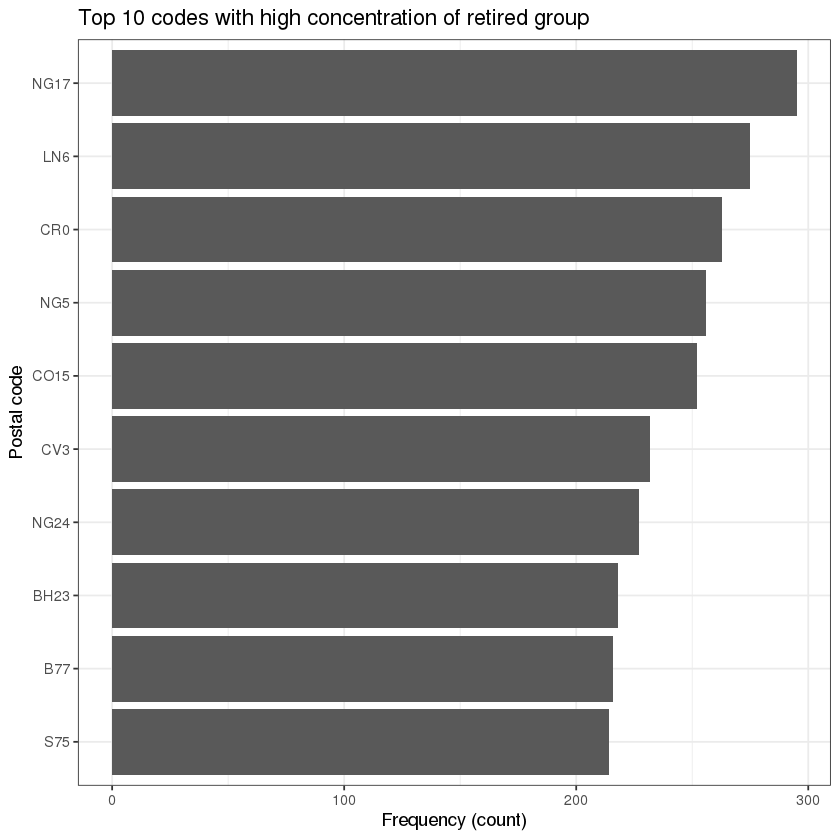

In [23]:
data_2020 %>% filter(CUSTOMER_SEGMENT == 7) %>% 
                                group_by(OUTCODE) %>% summarise(total = n()) %>%
                                arrange(desc(total)) %>% top_n(10) %>%
                                ggplot(aes(x = reorder(OUTCODE, total), y = total)) +
                                geom_col() +
                                coord_flip() +
                                labs(title = "Top 10 codes with high concentration of retired group",
                                         y = "Frequency (count)",
                                         x = "Postal code") +
                                theme_bw()

In [24]:
csc.query2 <- "
              SELECT * FROM `dcw-data-platform-analysis.Bui.CPCW_delivery_frequency`
              WHERE OUTCODE IN ('NG17','LN6','CR0','CO15','NG5','CV3','NG24',
                                'BH23','B77','S75')
"

In [25]:
data_csc_2 <- bq_table_download(
    bq_project_query(
        PROJECT_ID,
        query = csc.query2
    )
)

Auto-refreshing stale OAuth token.



In [26]:
data_csc_2 %>% distinct()

CSC         DLC   OUTCODE Type                                           
1  Leeds       74650 S75     Technical Install (Gas, Electric, Built in etc)
2  Leeds       74650 S75     General                                        
3  Newark      74309 NG24    Technical Install (Gas, Electric, Built in etc)
4  Newark      74309 LN6     Technical Install (Gas, Electric, Built in etc)
5  Newark      74309 NG5     Technical Install (Gas, Electric, Built in etc)
6  Newark      74309 LN6     Technical Install (Gas, Electric, Built in etc)
7  Newark      74309 NG17    Technical Install (Gas, Electric, Built in etc)
8  Newark      74309 LN6     General                                        
9  Newark      74309 NG17    General                                        
10 Newark      74309 LN6     General                                        
11 Newark      74309 NG24    General                                        
12 Newark      74309 NG5     General                                        
13 Snodland    74260 CR0     Technical Install (Gas, Electric, Built in etc)
14 Snodland    74260 CR0     General                                        
15 Thetford    74220 CO15    Technical Install (Gas, Electric, Built in etc)
16 Thetford    74220 CO15    General                                        
17 Birmingham  74290 B77     Technical Install (Gas, Electric, Built in etc)
18 Birmingham  74290 CV3     Technical Install (Gas, Electric, Built in etc)
19 Birmingham  74290 CV3     General                                        
20 Birmingham  74290 B77     General                                        
21 Gillingham  74266 CR0     Technical Install (Gas, Electric, Built in etc)
22 Gillingham  74266 CR0     General                                        
23 Basingstoke 74215 BH23    Technical Install (Gas, Electric, Built in etc)
24 Basingstoke 74215 BH23    General                                        
25 Basingstoke 74215 BH23    General                                        
   Visit_Days                  Visit_Frequency
1  Tue,Sat                     2.0            
2  Sun,Mon,Tue,Wed,Thu,Fri,Sat 7.0            
3  Mon,Fri                     2.0            
4  Mon,Fri                     2.0            
5  Sun,Wed                     2.0            
6  Tue,Fri                     2.0            
7  Wed,Sat                     2.0            
8  Sun,Tue,Wed,Fri             4.0            
9  Mon,Wed,Thu,Fri,Sat         5.0            
10 Mon,Tue,Wed,Thu,Fri,Sat     6.0            
11 Mon,Tue,Wed,Thu,Fri,Sat     6.0            
12 Sun,Mon,Tue,Wed,Thu,Fri,Sat 7.0            
13 Mon-Even Week,Thu,Sat       2.5            
14 Sun,Mon,Tue,Wed,Thu,Fri,Sat 7.0            
15 Wed,Sat                     2.0            
16 Tue,Wed,Fri.Sat             4.0            
17 Wed,Sat                     2.0            
18 Wed,Sat                     2.0            
19 Sun,Mon,Wed,Thu,Sat         5.0            
20 Sun,Mon,Tue,Wed,Thu,Fri,Sat 7.0            
21 Mon-Even Week,Thu,Sat       2.5            
22 Sun,Mon,Tue,Wed,Thu,Fri,Sat 7.0            
23 Tue,Fri                     2.0            
24 Sun,Tue,Fri                 3.0            
25 Sun,Tue,Wed,Fri             4.0

In [30]:
CRO <- data_2020 %>% filter(OUTCODE == "CR0")

prop.table(table(CRO$CUSTOMER_SEGMENT))


         0          1          2          3          4          5          6 
0.18143460 0.11687764 0.16455696 0.08143460 0.03839662 0.23291139 0.07341772 
         7 
0.11097046 

In [31]:
nrow(CRO)

[1] 2725

In [42]:
#segment_percent <- data_2020 %>% group_by(OUTCODE, CUSTOMER_SEGMENT) %>%
                  #summarise(Percent=n()) %>% 
                  #group_by(OUTCODE) %>% 
                  #mutate(Percentage=Percent/sum(Percent)*100) 


`summarise()` regrouping output by 'OUTCODE' (override with `.groups` argument)

